## Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do mch of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

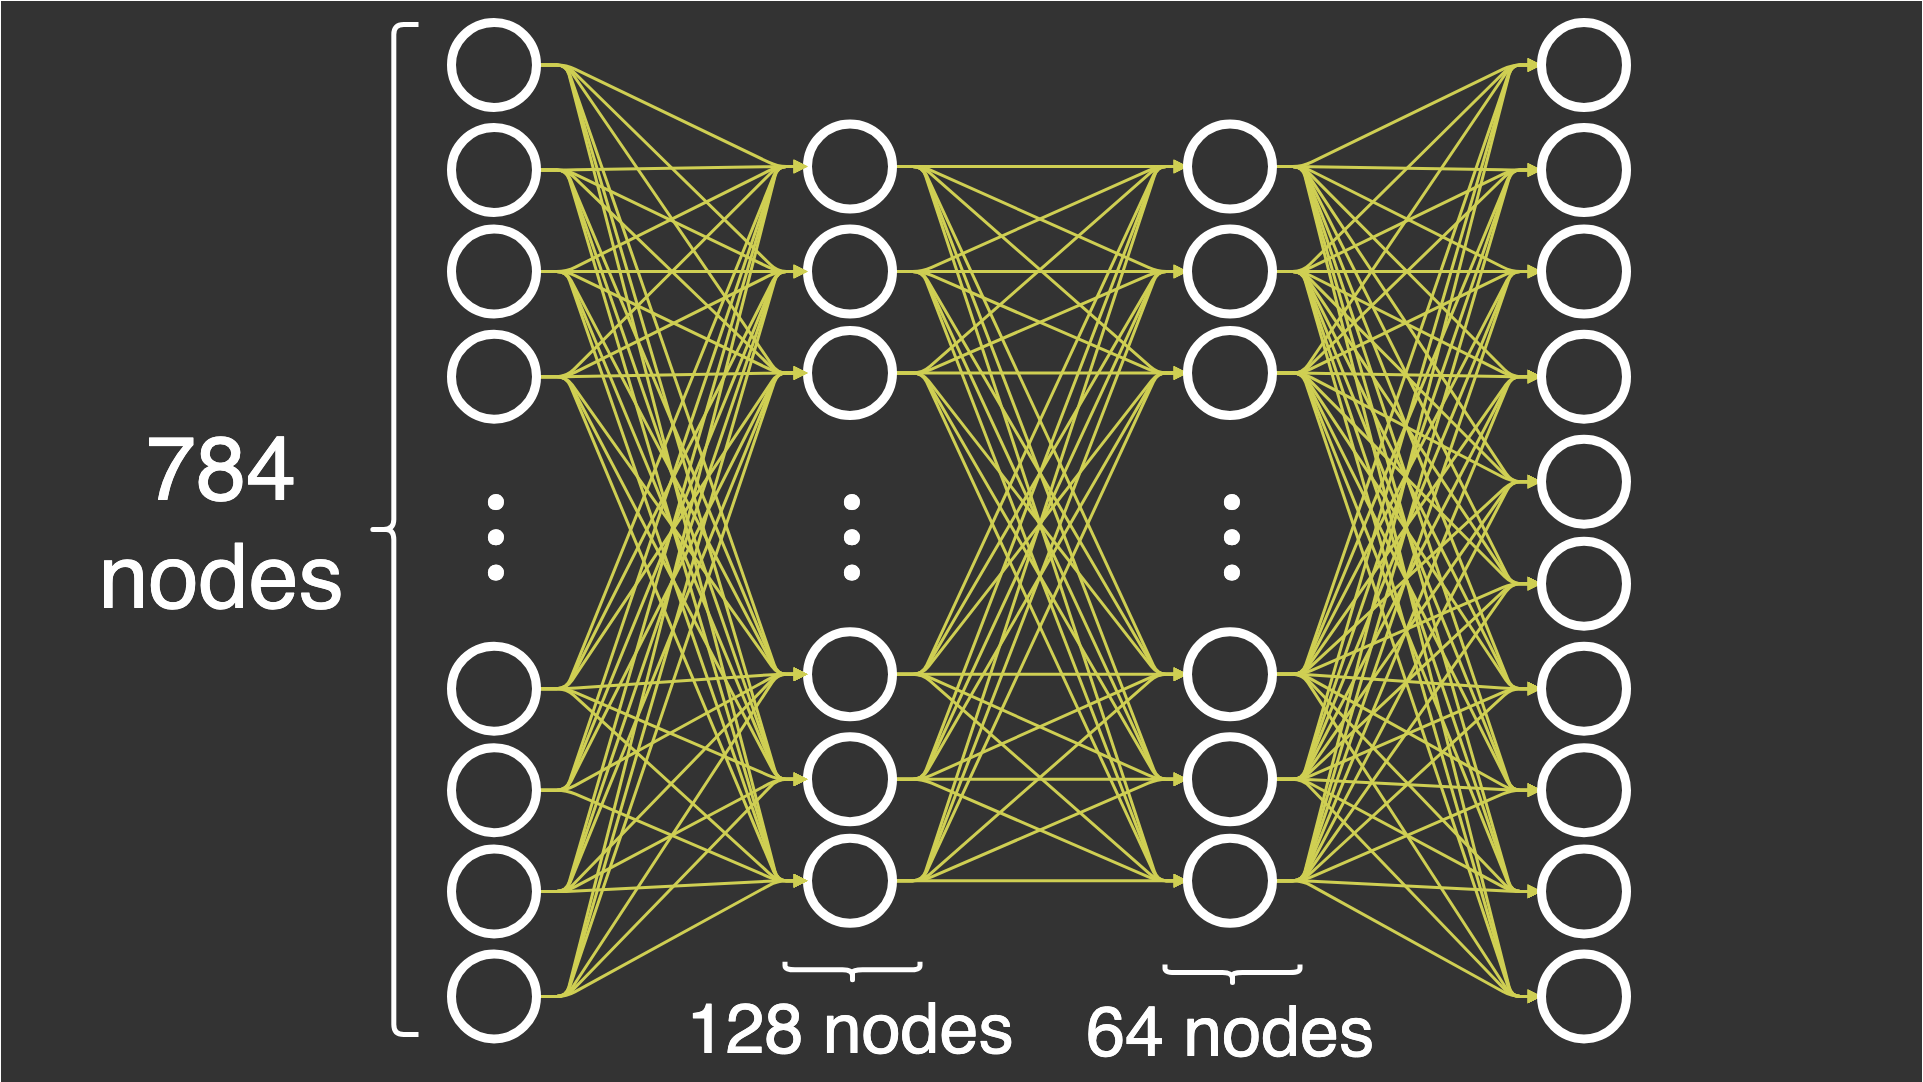

Milestone 1: Project infrastructure, Installing essential tools required for project and Trained model from scratch.

## Dataset

For this walkthrough, we will focus on importing the MNIST dataset and using that as the input to our deep neural networks. Note that this is purely a demonstration of how to make a neural network from scratch, and it is NOT the recommended architecture for solving the MNIST problem. We will reuse some code from one of the other articles on [Activation Functions Explained](https://mlfromscratch.com/activation-functions-explained/).

In [3]:
# Using Mnist dataset from Numpy

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'api.openml.org'. (_ssl.c:1010)>

In [ ]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
y[0]

NameError: name 'y' is not defined

In [ ]:
print(y[3])

NameError: name 'y' is not defined

## 4-layer Neural Network with NumPy

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(params['Z3'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    # def compute_accuracy(self, x_val, y_val):
    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         pred = np.argmax(output)
    #         predictions.append(pred == np.argmax(y))

    #     return np.mean(predictions)

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

Epoch: 1, Time Spent: 32.26s, Accuracy: 24.70%
Epoch: 1, Time Spent: 32.26s, Accuracy: 25.30%
Epoch: 1, Time Spent: 32.26s, loss: 0.47
Epoch: 1, Time Spent: 32.26s, loss: 0.29
-------------------------------------------------------------
Epoch: 2, Time Spent: 64.03s, Accuracy: 26.04%
Epoch: 2, Time Spent: 64.03s, Accuracy: 26.25%
Epoch: 2, Time Spent: 64.03s, loss: 0.39
Epoch: 2, Time Spent: 64.03s, loss: 0.29
-------------------------------------------------------------
Epoch: 3, Time Spent: 95.13s, Accuracy: 28.50%
Epoch: 3, Time Spent: 95.13s, Accuracy: 28.88%
Epoch: 3, Time Spent: 95.13s, loss: 0.35
Epoch: 3, Time Spent: 95.13s, loss: 0.28
-------------------------------------------------------------
Epoch: 4, Time Spent: 127.29s, Accuracy: 31.87%
Epoch: 4, Time Spent: 127.30s, Accuracy: 32.83%
Epoch: 4, Time Spent: 127.30s, loss: 0.34
Epoch: 4, Time Spent: 127.30s, loss: 0.26
-------------------------------------------------------------
Epoch: 5, Time Spent: 159.25s, Accuracy: 37.

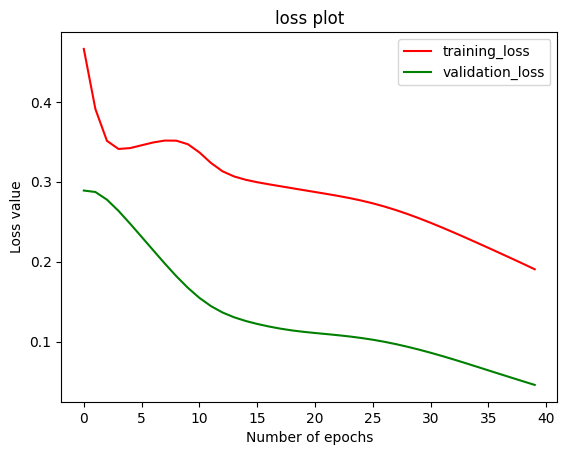

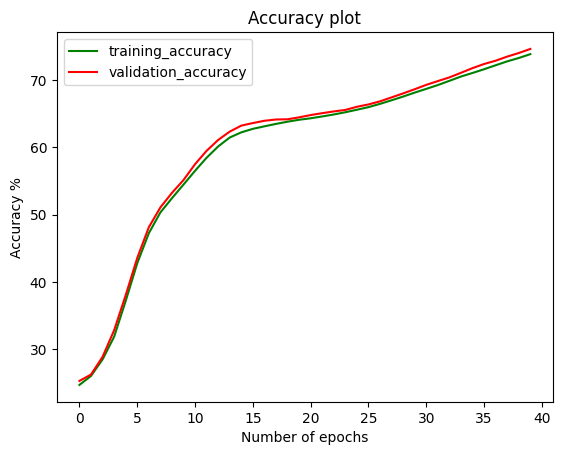

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=40, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)


Epoch: 1, Time Spent: 30.94s, Accuracy: 63.60%
Epoch: 1, Time Spent: 30.94s, Accuracy: 64.63%
Epoch: 1, Time Spent: 30.94s, loss: 0.64
Epoch: 1, Time Spent: 30.94s, loss: 0.15
-------------------------------------------------------------
Epoch: 2, Time Spent: 63.06s, Accuracy: 71.28%
Epoch: 2, Time Spent: 63.06s, Accuracy: 72.01%
Epoch: 2, Time Spent: 63.06s, loss: 1.22
Epoch: 2, Time Spent: 63.06s, loss: 0.04
-------------------------------------------------------------
Epoch: 3, Time Spent: 95.75s, Accuracy: 77.66%
Epoch: 3, Time Spent: 95.75s, Accuracy: 78.37%
Epoch: 3, Time Spent: 95.75s, loss: 0.98
Epoch: 3, Time Spent: 95.75s, loss: 0.02
-------------------------------------------------------------
Epoch: 4, Time Spent: 127.05s, Accuracy: 79.92%
Epoch: 4, Time Spent: 127.05s, Accuracy: 80.68%
Epoch: 4, Time Spent: 127.05s, loss: 0.91
Epoch: 4, Time Spent: 127.05s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 159.00s, Accuracy: 80.

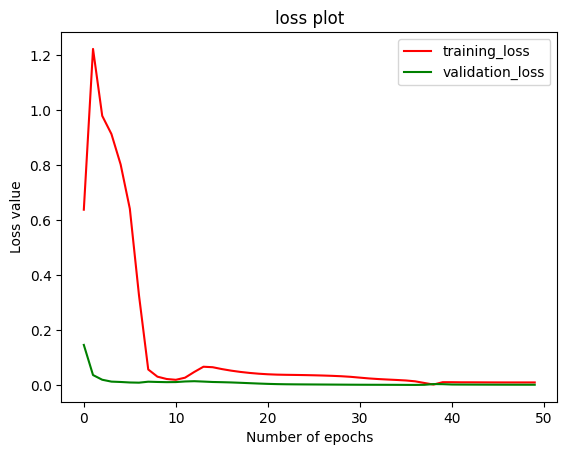

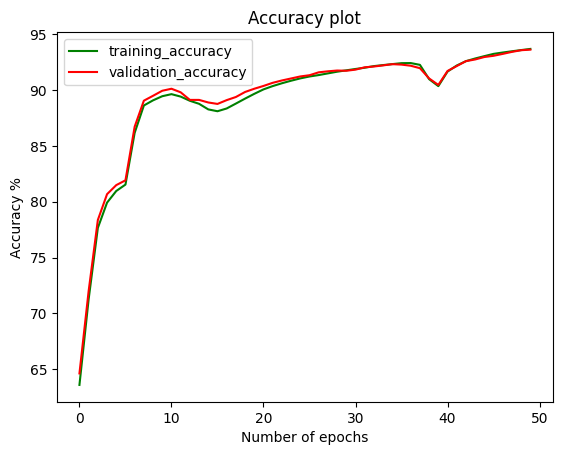

In [ ]:
dnn1 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.01)
dnn1.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

Epoch: 1, Time Spent: 30.66s, Accuracy: 76.56%
Epoch: 1, Time Spent: 30.66s, Accuracy: 76.95%
Epoch: 1, Time Spent: 30.66s, loss: 0.08
Epoch: 1, Time Spent: 30.66s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 62.28s, Accuracy: 87.42%
Epoch: 2, Time Spent: 62.28s, Accuracy: 87.59%
Epoch: 2, Time Spent: 62.28s, loss: 0.03
Epoch: 2, Time Spent: 62.28s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 93.03s, Accuracy: 90.01%
Epoch: 3, Time Spent: 93.03s, Accuracy: 90.39%
Epoch: 3, Time Spent: 93.03s, loss: 0.03
Epoch: 3, Time Spent: 93.03s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 124.47s, Accuracy: 91.24%
Epoch: 4, Time Spent: 124.47s, Accuracy: 91.49%
Epoch: 4, Time Spent: 124.47s, loss: 0.03
Epoch: 4, Time Spent: 124.47s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 154.83s, Accuracy: 91.

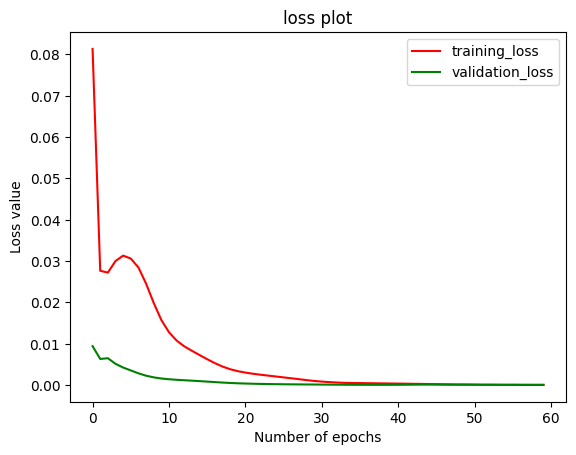

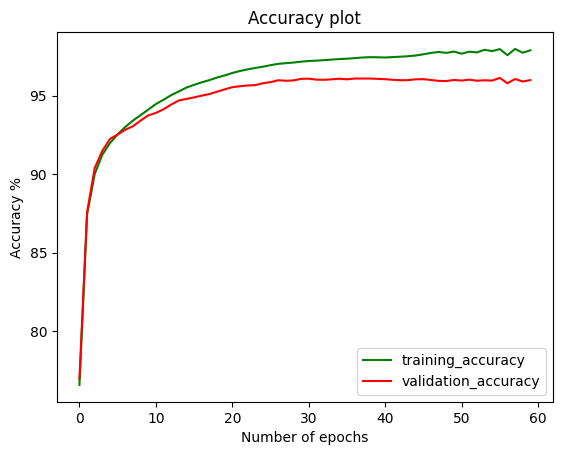

In [ ]:
dnn2 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=60, l_rate=0.05)
dnn2.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
dnn3 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=100, l_rate=0.7)
dnn3.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

NameError: name 'DeepNeuralNetwork' is not defined

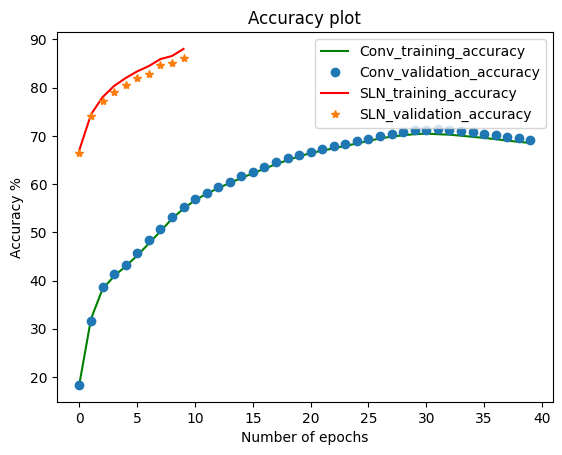

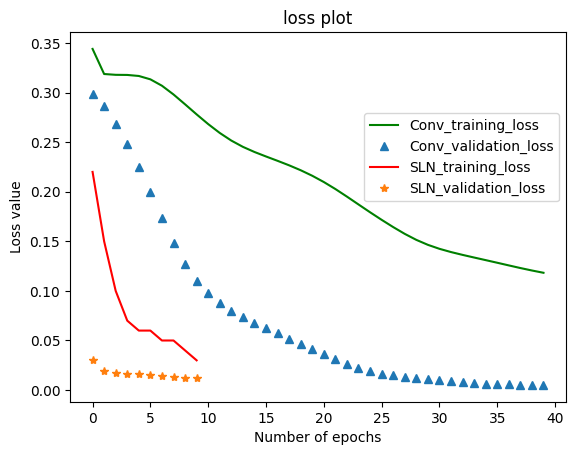

In [ ]:
#Ran in server and extracted results
SLN = {'Train_acc':[67.12,74.43,78.02,80.34,81.98,83.36,84.46,85.9,86.54,88.01],
       'Val_acc':[66.49,74.10,77.16,79.09,80.56,82.07,82.90,84.68,85.14,86.19]}

_SLN = {'Train_loss':[0.22,0.15,0.10,0.07,0.06,0.06,0.05,0.05,0.04,0.03],
       'Val_loss':[0.03,0.019,0.017,0.016,0.016,0.015,0.014,0.013,0.012,0.012]}


plt.figure(1)
plt.plot(np.array(dnn.tacc),'g',label='Conv_training_accuracy')
plt.plot(np.array(dnn.vacc),'o',label='Conv_validation_accuracy')
plt.plot(SLN['Train_acc'],'r',label='SLN_training_accuracy')
plt.plot(SLN['Val_acc'],'*',label='SLN_validation_accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy plot")
plt.legend()

plt.figure(2)
plt.plot(dnn.tls,'g',label='Conv_training_loss')
plt.plot(dnn.vls,'^',label='Conv_validation_loss')
plt.plot(_SLN['Train_loss'],'r',label='SLN_training_loss')
plt.plot(_SLN['Val_loss'],'*',label='SLN_validation_loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.title("loss plot")
plt.legend(loc='upper right',bbox_to_anchor=(1.0, 0.8))

Epoch: 1, Time Spent: 2.99s, Accuracy: 11.90%
Epoch: 1, Time Spent: 2.99s, Accuracy: 15.00%
Epoch: 1, Time Spent: 2.99s, loss: 0.27
Epoch: 1, Time Spent: 2.99s, loss: 0.29
-------------------------------------------------------------
Epoch: 2, Time Spent: 5.99s, Accuracy: 15.13%
Epoch: 2, Time Spent: 5.99s, Accuracy: 13.33%
Epoch: 2, Time Spent: 5.99s, loss: 0.28
Epoch: 2, Time Spent: 5.99s, loss: 0.30
-------------------------------------------------------------
Epoch: 3, Time Spent: 9.71s, Accuracy: 17.88%
Epoch: 3, Time Spent: 9.71s, Accuracy: 18.33%
Epoch: 3, Time Spent: 9.71s, loss: 0.29
Epoch: 3, Time Spent: 9.71s, loss: 0.30
-------------------------------------------------------------
Epoch: 4, Time Spent: 12.80s, Accuracy: 19.82%
Epoch: 4, Time Spent: 12.80s, Accuracy: 20.00%
Epoch: 4, Time Spent: 12.80s, loss: 0.30
Epoch: 4, Time Spent: 12.80s, loss: 0.31
-------------------------------------------------------------
Epoch: 5, Time Spent: 15.91s, Accuracy: 20.13%
Epoch: 5, Tim

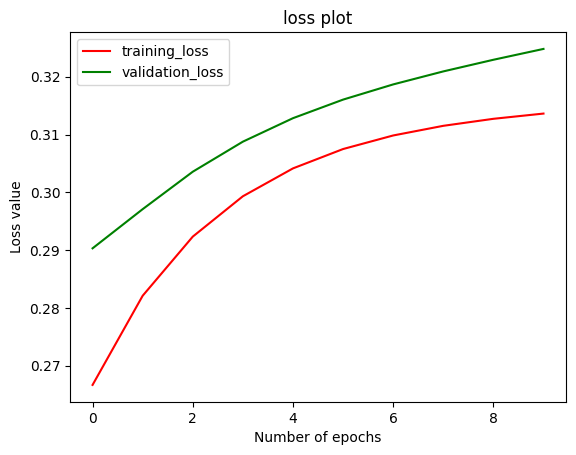

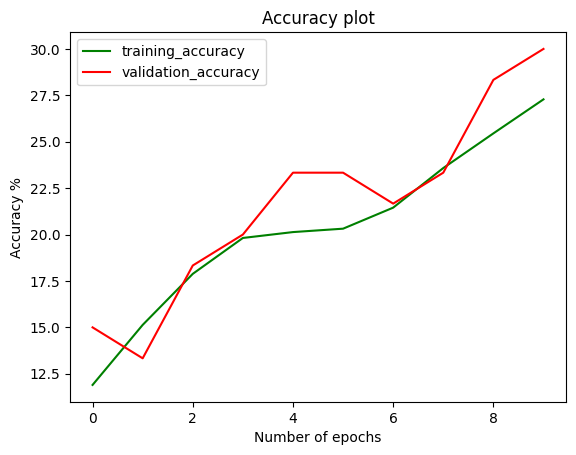

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784)[:6000], y_train[:6000], x_val.reshape(10000,784)[:60], y_val[:60])

Epoch: 1, Time Spent: 3.38s, Accuracy: 13.60%
Epoch: 1, Time Spent: 3.38s, Accuracy: 13.00%
Epoch: 1, Time Spent: 3.38s, loss: 0.29
Epoch: 1, Time Spent: 3.38s, loss: 0.38
-------------------------------------------------------------
Epoch: 2, Time Spent: 6.45s, Accuracy: 13.12%
Epoch: 2, Time Spent: 6.45s, Accuracy: 12.80%
Epoch: 2, Time Spent: 6.45s, loss: 0.28
Epoch: 2, Time Spent: 6.45s, loss: 0.36
-------------------------------------------------------------
Epoch: 3, Time Spent: 9.57s, Accuracy: 12.87%
Epoch: 3, Time Spent: 9.57s, Accuracy: 11.80%
Epoch: 3, Time Spent: 9.57s, loss: 0.29
Epoch: 3, Time Spent: 9.57s, loss: 0.34
-------------------------------------------------------------
Epoch: 4, Time Spent: 13.32s, Accuracy: 12.67%
Epoch: 4, Time Spent: 13.32s, Accuracy: 12.20%
Epoch: 4, Time Spent: 13.32s, loss: 0.29
Epoch: 4, Time Spent: 13.32s, loss: 0.34
-------------------------------------------------------------
Epoch: 5, Time Spent: 16.47s, Accuracy: 15.15%
Epoch: 5, Tim

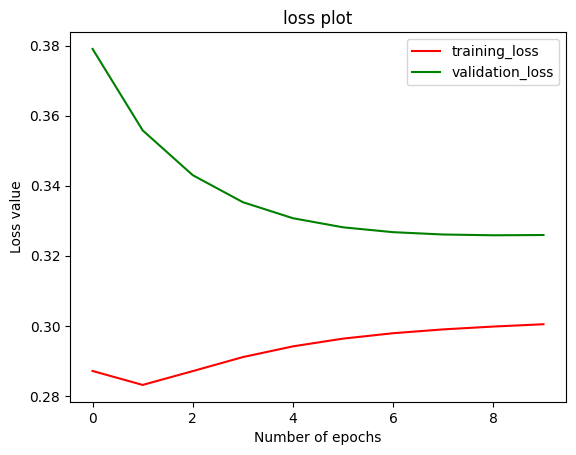

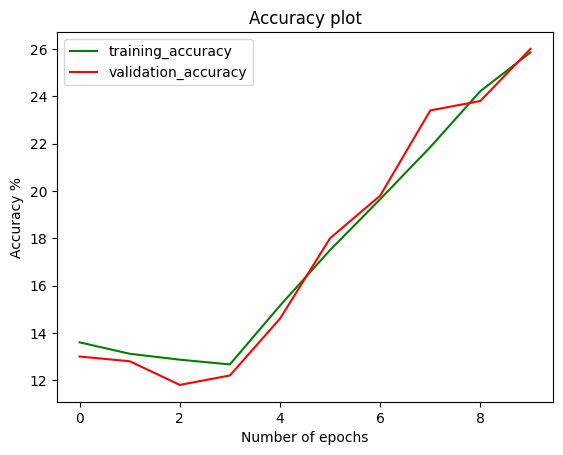

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784)[:6000], y_train[:6000], x_val.reshape(10000,784)[:500], y_val[:500])

## Seven layer network

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        hidden_3=self.sizes[3]
        hidden_4=self.sizes[4]
        hidden_5=self.sizes[5]
        hidden_6=self.sizes[6]
        output_layer=self.sizes[7]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(hidden_3, hidden_2) * np.sqrt(1. / hidden_3),
            'W4':np.random.randn(hidden_4, hidden_3) * np.sqrt(1. / hidden_4),
            'W5':np.random.randn(hidden_5, hidden_4) * np.sqrt(1. / hidden_5),
            'W6':np.random.randn(hidden_6, hidden_5) * np.sqrt(1. / hidden_6),
            'W7':np.random.randn(output_layer, hidden_6) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to hidden layer 3
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.sigmoid(params['Z3'])

        # hidden layer 3 to hidden layer 4
        params['Z4'] = np.dot(params["W4"], params['A3'])
        params['A4'] = self.sigmoid(params['Z4'])

        # hidden layer 4 to hidden layer 5
        params['Z5'] = np.dot(params["W5"], params['A4'])
        params['A5'] = self.sigmoid(params['Z5'])

        # hidden layer 5 to hidden layer 6
        params['Z6'] = np.dot(params["W6"], params['A5'])
        params['A6'] = self.sigmoid(params['Z6'])

        # hidden layer 6 to output layer (which is hidden layer 7 in the problem statement)
        params['Z7'] = np.dot(params["W7"], params['A6'])
        params['A7'] = self.softmax(params['Z7'])

        return params['A7']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        # Calculate W7 update (output layer)
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z7'], derivative=True)
        change_w['W7'] = np.outer(error, params['A6'])

        # Calculate W6 update
        error = np.dot(params['W7'].T, error) * self.sigmoid(params['Z6'], derivative=True)
        change_w['W6'] = np.outer(error, params['A5'])

        # Calculate W5 update
        error = np.dot(params['W6'].T, error) * self.sigmoid(params['Z5'], derivative=True)
        change_w['W5'] = np.outer(error, params['A4'])

        # Calculate W4 update
        error = np.dot(params['W5'].T, error) * self.sigmoid(params['Z4'], derivative=True)
        change_w['W4'] = np.outer(error, params['A3'])

        # Calculate W3 update
        error = np.dot(params['W4'].T, error) * self.sigmoid(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)


In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 128, 128, 64, 64, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

## CUPY in GPU

In [ ]:
!pip install cupy
import cupy as cp

  Using cached cupy-13.6.0.tar.gz (3.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Operation cancelled by user


In [ ]:
from sklearn.metrics import accuracy_score
import cupy as cp

class cDeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (cp.exp(-x))/((cp.exp(-x)+1)**2)
        return 1/(1 + cp.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = cp.exp(x - x.max())
        if derivative:
            return exps / cp.sum(exps, axis=0) * (1 - exps / cp.sum(exps, axis=0))
        return exps / cp.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':cp.asarray(np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1)),
            'W2':cp.asarray(np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2)),
            'W3':cp.asarray(np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer))
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = cp.dot(cp.asarray(params["W1"]), cp.asarray(params['A0']))
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(cp.asarray(params['Z1']))
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        #print("Axis dimension",np.shape(cp.asarray(params["W2"])))
        params['Z2'] = cp.dot(cp.asarray(params["W2"]), cp.asarray(params['A1']))
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(cp.asarray(params['Z2']))
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = cp.dot(cp.asarray(params["W3"]), cp.asarray(params['A2']))
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(cp.asarray(params['Z3']))
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0]  * self.softmax(cp.asarray(params['Z3']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W3'] = np.outer(error, params['A2'])
        change_w['W3'] = cp.tensordot(error[:, cp.newaxis], params['A2'][cp.newaxis, :], axes=0)

        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(cp.asarray(params['W3'].T), error) * self.sigmoid(cp.asarray(params['Z2']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W2'] = np.outer(error, params['A1'])
        change_w['W2'] = cp.tensordot(error[:, cp.newaxis], params['A1'][cp.newaxis, :], axes=0)
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(cp.asarray(params['W2'].T), error) * self.sigmoid(cp.asarray(params['Z1']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W1'] = np.outer(error, params['A0'])
        change_w['W1'] = cp.tensordot(error[:, cp.newaxis], cp.asarray(params['A0'])[cp.newaxis, :], axes=0)
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            #print("check type",key,type(self.params[key]))
            #print("check type v",type(value))
            #print("b_shape",key,np.shape(value),type(value))
            self.params[key] = self.params[key] - self.l_rate * np.squeeze(value)
            #print("shape",key,np.shape(self.params[key]))

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            res = pred == np.argmax(y)
            predictions.append(res)
            #print("predictions",predictions)
        return cp.mean(cp.asarray(predictions))

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            #print("----------------iteration {}------------".format(iteration))
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
                #print("-----------------count {}------------------".format(count))
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(cp.asarray(y), cp.asarray(output))
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)

            #accuracy = accuracy_score(out, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100 ))

In [ ]:
import numpy as np
dnn = cDeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

NameError: name 'x_train' is not defined

In [ ]:
t = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(np.shape(t))
print(np.shape(cp.asarray(cp.asarray(t))))

(3, 3)
(3, 3)


In [ ]:
import random
np.shape(x_train)
UL = random.sample(range(1, 60000), 600)
_x_train = x_train[UL]
_y_train = y_train[UL]

UP = random.sample(range(1, 10000), 100)
_x_val = x_val[UP]
_y_val = y_val[UP]

import matplotlib.pyplot as plt
plt.imshow(_x_val[99])
print(_y_val[99])

NameError: name 'x_train' is not defined

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(_x_train.reshape(600,784), _y_train, _x_val.reshape(100,784), _y_val)

NameError: name 'DeepNeuralNetwork' is not defined

In [ ]:
import numpy as np
data = np.load('./mn_data.npy',allow_pickle=True)
_x_train = data.item()['x_train']
_y_train = data.item()['y_train']
_x_val = data.item()['x_val']
_y_val = data.item()['y_val']

FileNotFoundError: [Errno 2] No such file or directory: './mn_data.npy'

In [ ]:
import time
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.001)
dnn.train(_x_train.reshape(6000,784)[:600], _y_train[:600], _x_val.reshape(500,784)[:50], _y_val[:50])

NameError: name 'DeepNeuralNetwork' is not defined

### Results

Completely dependent on how the weights are initialized, we get different results. Sometimes we are stuck at 0% accuracy, sometimes 5-10%, other times it jumps from 22% to 94.5%. If you want to experiment, try using a seed for numpy by `np.random.seed(42)` or any other number. Then you should get the same results each time.

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

NameError: name 'x_train' is not defined

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 120, 80, 10])
dnn.train(np.array(x_train), y_train, np.array(x_val), y_val)

NameError: name 'DeepNeuralNetwork' is not defined

## Gate Network

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


NameError: name 'to_categorical' is not defined

In [ ]:
import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class GateNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate


        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    import numpy as np

    def relu(self, x, derivative=False):
        if derivative:
            return(np.where(x > 0, 1, 0))  # Compute gradient of ReLU function
        return (np.maximum(0, x))

    def relu_old(self, x, derivative=False):
        if derivative:
          return (1 * (x>0))
        return (x * (x>0))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        np.random.seed(42)
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'E' :[],
            'FWC':[],
            'MWC':[],
            'LWC':[],
        }
        np.save('ini_weights',params)
        return params

    def forward_pass(self, x_train, iteration, logs=False):

        params = self.params
        km = 100
        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('W first layer', params['W1'])
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Z first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])


        # hidden layer 1 to hidden layer 2
        # print('W second layer', params['W2'])
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Z second layer', params['Z2'])
        params['A2'] = self.sigmoid(params['Z2'])


        # hidden layer 2 to output layer
        #print('W third layer', params['W3'])
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Z third layer', params['Z3'])
        params['A3'] = self.sigmoid(params['Z3'])
        print('Third layer activation', params['A3'])
        if logs == True and iteration % km == 0:
            print("---------------------First layer--------------------------")
            print('First layer Weights', params['W1'])
            print('First layer Activation', params['A1'])

            print("---------------------Second layer--------------------------")
            print('Second layer weights', params['W2'])
            print('Second layer activation', params['A2'])

            print("---------------------Third layer--------------------------")
            print('Third layer weights', params['W3'])
            print('Third layer activation', params['A3'])


        return params['A3']

    def backward_pass(self, y_train, output, iteration, count, logs=False):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}
        nm = 1
        # Calculate W3 update
        _error = self.binary_cross_entrophy(y_train, output, derivative=True)
        if(count == 1):
            self.params['E'].append(_error[0])
        error = _error * self.sigmoid(params['Z3'], derivative=True)
        #error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])
        if (count == -1):
            print("Error last layer", error)
            print("Change weight last layer", change_w['W3'])
            self.params['LWC'].append((np.sum(change_w['W3'])))
            print("--------------------------------------------")

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])
        if (count == -1):
            print("Error middle layer", error)
            print("Change weight middle layer ", change_w['W2'])
            self.params['MWC'].append(np.sum(np.sum(change_w['W2'])))
            print("--------------------------------------------")

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])
        if (count == -1):
            print("Error first layer", error)
            print("Change weight first layer", change_w['W1'])
            self.params['FWC'].append(np.sum(np.sum(change_w['W1'])))
            print("--------------------------------------------")
        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_loss(self, output, y_train):

        return((output - y_train)**2)

    def compute_accuracy(self, x_val, y_val):

        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x, 1, logs=False)
            #print("output",output)
            #pred = np.argmax(output)
            #predictions.append(pred == np.argmax(y))
            if output > 0.5:
               out = 1
            else:
               out = 0
            predictions.append(out)
        return predictions

    def train(self, x_train, y_train, x_val, y_val):
        #predictions = []
        start_time = time.time()
        self.ls=[]
        self.acc=[]
        for iteration in range(self.epochs):
            count=0
            print("---------------------Epoch {}--------------------------".format(iteration))
            for x, y in zip(x_train, y_train):
                count+=1
                print("---------------------Sample {}--------------------------".format(count))
                output = self.forward_pass(x, iteration, logs=False)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output, iteration, count, logs = False )
          #      print("-------------------------------Backprop")
                #for k,v in changes_to_w.items():
                #    print(k,v)
                #print("-----------Sample{}-------------".format(count))
                self.update_network_parameters(changes_to_w)
            #print("---------------------End of Epoch---------------------")
            loss = self.binary_cross_entrophy(y_train, output, derivative=False)
            #loss = self.compute_loss(output,y_train)
            out = self.compute_accuracy(x_val, y_val)
            #print("Predictions",out)
            #print("Loss",out)
            accuracy = accuracy_score(out, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100 ))
            self.ls.append(np.mean(loss))
            self.acc.append(accuracy)
        np.save('final_weights',self.params)
        plt.figure(1)
        plt.plot(self.ls)
        plt.title("loss")
        plt.figure(2)
        plt.plot(self.acc,'r')
        plt.title("Accuracy")
        # plt.figure(3)
        # plt.plot(self.params['FWC'],'g')
        # plt.title("Weight change over epochs First layer")
        # plt.figure(4)
        # plt.plot(self.params['MWC'],'y')
        # plt.title("Weight change over epochs middle layer")
        # plt.figure(5)
        # plt.plot(self.params['LWC'],'b')
        # plt.title("Weight change over epochs last layer")
        # plt.figure(6)
        # plt.plot(self.params['E'],'o')
        # plt.title("Error change over epochs last layer")


Streaming output truncated to the last 5000 lines.
Third layer activation [0.66145431]
Third layer activation [0.35144402]
Third layer activation [0.42235812]
Third layer activation [0.53158289]
Third layer activation [0.4907141]
Third layer activation [0.3637295]
Third layer activation [0.58729896]
Third layer activation [0.43342235]
Third layer activation [0.54424269]
Third layer activation [0.50836695]
Third layer activation [0.61338873]
Third layer activation [0.55479727]
Third layer activation [0.65013245]
Third layer activation [0.59606985]
Third layer activation [0.56998281]
Third layer activation [0.62911166]
Third layer activation [0.66145431]
Epoch: 3906, Time Spent: 20.56s, Accuracy: 82.35%
---------------------Epoch 3906--------------------------
---------------------Sample 1--------------------------
Third layer activation [0.66145431]
---------------------Sample 2--------------------------
Third layer activation [0.35154397]
---------------------Sample 3------------------

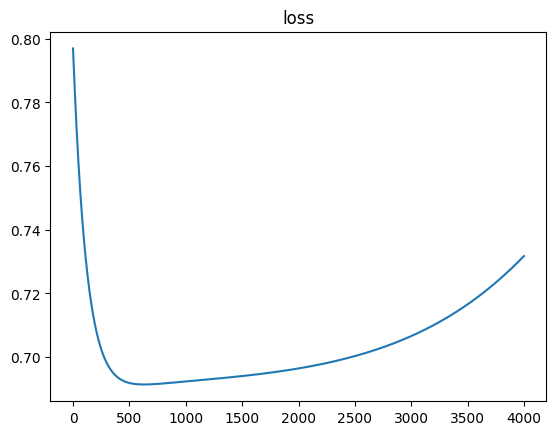

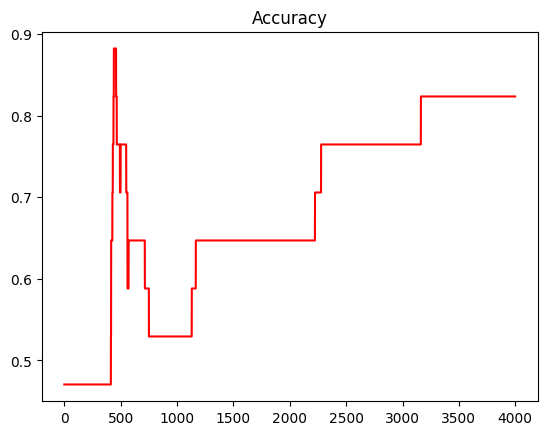

In [ ]:
#X_train = np.array([[0,0,0],[0,0,1],[0,1,1],[1,1,0],[1,0,1],[1,1,1],[0,1,0],[1,0,0]])
#Y_train = np.array([[0],[0],[1],[1],[1],[1],[0],[0]])
#X_val = X_train
#Y_val = Y_train
#print(np.shape(X_val))


# 16 Sample dataset
X_train = np.array([[1,1,1,1],[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]])
Y_train = np.array([[1],[0],[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[1],[1]])
X_val = X_train
Y_val = Y_train
#print(np.shape(X_val))
#X_val = np.array([[0,1,0,0],[1,1,1,0],[0,1,0,1]])
#Y_val = np.array([[0],[1],[0]])

#X_train = np.array([[0,0,0,1]])
#Y_train = np.array([[1]])
#X_val = X_train
#Y_val = Y_train

dnn = GateNeuralNetwork(sizes=[4, 4, 4, 1], epochs=4000, l_rate=0.001)
dnn.train(X_train, Y_train, X_val, Y_val)

{'W1': array([[ 0.24835708, -0.06913215,  0.32384427,  0.76151493],
       [-0.11707669, -0.11706848,  0.78960641,  0.38371736],
       [-0.23473719,  0.27128002, -0.23170885, -0.23286488],
       [ 0.12098114, -0.95664012, -0.86245892, -0.28114376]]), 'W2': array([[-0.50641556,  0.15712367, -0.45401204, -0.70615185],
       [ 0.73282438, -0.11288815,  0.0337641 , -0.71237409],
       [-0.27219136,  0.05546129, -0.57549679,  0.18784901],
       [-0.30031934, -0.14584687, -0.30085331,  0.92613909]]), 'W3': array([[-0.01349722, -1.05771093,  0.82254491, -1.22084365]]), 'E': [], 'FWC': [], 'MWC': [], 'LWC': []}
---------------------------------------------------
{'W1': array([[ 0.29069945,  0.04945814,  0.4049687 ,  0.77451051],
       [ 0.11385889,  0.35078332,  1.16956033,  0.45154999],
       [-0.44164951, -0.0934329 , -0.56793646, -0.38800428],
       [ 0.12637984, -1.37819541, -1.1090825 , -0.2315992 ]]), 'W2': array([[-0.27199735,  0.48472376, -0.5807575 , -1.08494975],
       [ 0.5

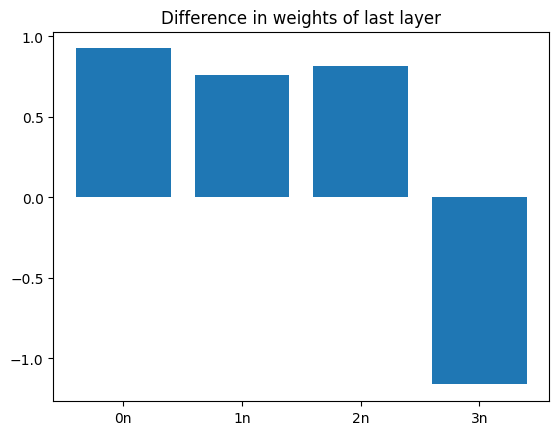

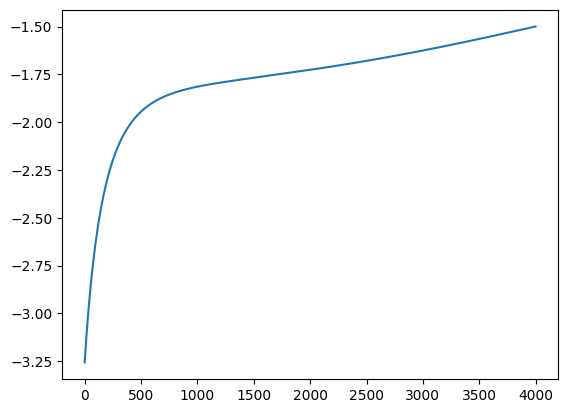

In [ ]:
import matplotlib.pyplot as plt

ini_weights = np.load("ini_weights.npy", allow_pickle=True)
print(ini_weights.item())
print("---------------------------------------------------")
final_weights = np.load("final_weights.npy", allow_pickle=True)
print(final_weights.item())
print("---------------------------------------------------")
diff = final_weights.item()['W3'][0] - ini_weights.item()['W3'][0]
plt.title("Difference in weights of last layer")
plt.bar(np.array(["0n", "1n", "2n", "3n"]), diff)
plt.figure(2)
plt.plot(final_weights.item()['E'])

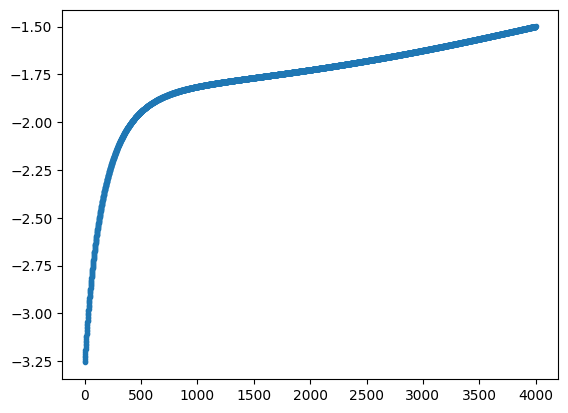

In [ ]:
plt.figure(2)
plt.plot(final_weights.item()['E'],'.')

In [ ]:
print("First minima iteration number and value", np.where(dnn.ls == min(dnn.ls)), min(dnn.ls))
print("Second minima iteration number and value", np.where(dnn.ls == np.sort(dnn.ls)[3]), np.sort(dnn.ls)[1])

First minima iteration number and value (array([629]),) 0.6914160776286539
Second minima iteration number and value (array([631]),) 0.6914160945106417


In [ ]:
print("First minima iteration number and value", np.where(dnn.ls == min(dnn.ls)), min(dnn.ls))
print("Second minima iteration number and value", np.where(dnn.ls == np.sort(dnn.ls)[1]), np.sort(dnn.ls)[1])

First minima iteration number and value (array([629]),) 0.6914160776286539
Second minima iteration number and value (array([630]),) 0.6914160945106417


## Loading MNIST with PyTorch

Importing with PyTorch is straight away more complicated than we saw previously. This was one of the things that threw me off at first, but it seems straight forward once you get what the DataLoader returns you, and how you can access the data in the objects.

In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform))

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transform))

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.07MB/s]


## 4-layer Neural Network With PyTorch

In [ ]:
for x,y in train_loader:
  print(np.shape(torch.flatten(x)))
  print(np.shape(y))
  break

torch.Size([784])
torch.Size([1])


In [ ]:
import numpy as np
X_train = np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]],dtype=np.compat.long)
Y_train = np.array([[0],[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[1],[1]],dtype=np.compat.long)
X_val = X_train
Y_val = Y_train

AttributeError: `np.compat` was removed in the NumPy 2.0 release. There's no replacement, as Python 2 is no longer supported.

In [ ]:
X_train.dtype

dtype('int64')

In [ ]:
import torch
xx = (torch.from_numpy(X_train).type(torch.LongTensor))
xx.dtype

torch.int64

In [ ]:
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, epochs=10):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(4, 4)
        self.linear2 = nn.Linear(4, 4)
        self.linear3 = nn.Linear(4, 1)

        self.epochs = epochs

    def forward_pass(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x

    def one_hot_encode(self, y):
        encoded = torch.zeros([1], dtype=torch.float64)
        encoded[y[0]] = 1.
        return encoded

    def train(self, X_train, Y_train, optimizer):
      #criterion
        start_time = time.time()
        loss = None

        for iteration in range(self.epochs):
            for x,y in zip(X_train, Y_train):
                #y = self.one_hot_encode(y)
                print((y))
                optimizer.zero_grad()
                output = self.forward_pass(torch.from_numpy(x).type(torch.LongTensor))
                loss = criterion(output, torch.from_numpy(y).type(torch.LongTensor))
                loss.backward()
                optimizer.step()

            print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(
                iteration+1, time.time() - start_time, loss
            ))

In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

model.train(X_train, Y_train, optimizer)

[1]


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

## TensorFlow 2.0 with Keras

Now that we know just how much code lies behind a simple neural network in NumPy and PyTorch, let's look at how easily we can construct the same network in TensorFlow (with Keras).

With TensorFlow and Keras, we don't have to think as much about activation functions, optimizers etc., since they are already implemented. On top of this, we will see huge improvements in the time it takes to execute and train a neural network, since the frameworks are completely optimized compared to NumPy.

The following approach goes for a complete Keras solution, without a custom training function or anything very TensorFlow related. Go to the end of my [TensorFlow 2.0 tutorial](https://mlfromscratch.com/tensorflow-2/#custom-train-and-test-functions-in-tensorflow-2-0) to see what a custom training function looks like.

In [ ]:
!pip install --upgrade tensorflow-gpu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
# Not using this code
#import numpy as np
#X_train = np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,1]])
#Y_train = np.array([[0],[0],[0],[0],[1],[0],[0],[1],[1],[1],[1],[1],[1]])
#X_val = np.array([[0,1,0,0],[1,1,1,0],[0,1,0,1]])
#Y_val = np.array([[0],[1],[0]])

In [ ]:
model = tf.keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

#history = model.fit(X_train.reshape(13,1,4), Y_train, validation_data=(X_val.reshape(3,1,4), Y_val), epochs=2000)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5825 - loss: 0.2282 - val_accuracy: 0.9124 - val_loss: 0.0602
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9137 - loss: 0.0564 - val_accuracy: 0.9319 - val_loss: 0.0425
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9372 - loss: 0.0399 - val_accuracy: 0.9481 - val_loss: 0.0325
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9512 - loss: 0.0312 - val_accuracy: 0.9564 - val_loss: 0.0279
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9595 - loss: 0.0251 - val_accuracy: 0.9621 - val_loss: 0.0232
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9677 - loss: 0.0215 - val_accuracy: 0.9651 - val_loss: 0.0210
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9705 - loss: 0.0190 - val_accuracy: 0.9680 - val_loss: 0.0194
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9751 - loss: 0

Text(0.5, 1.0, 'Acc')

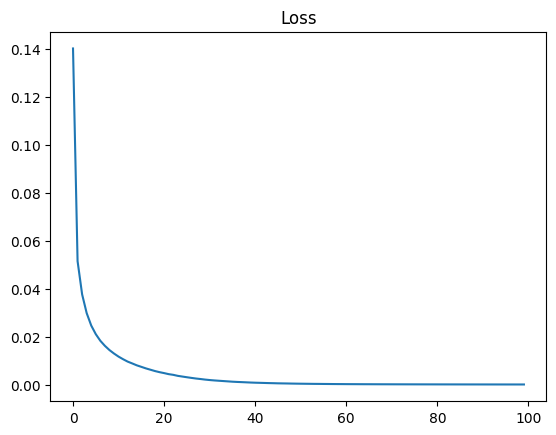

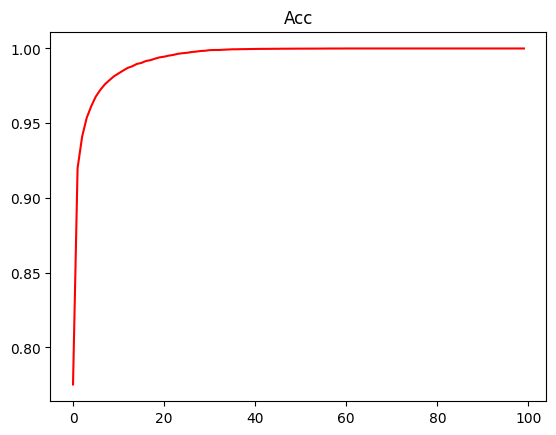

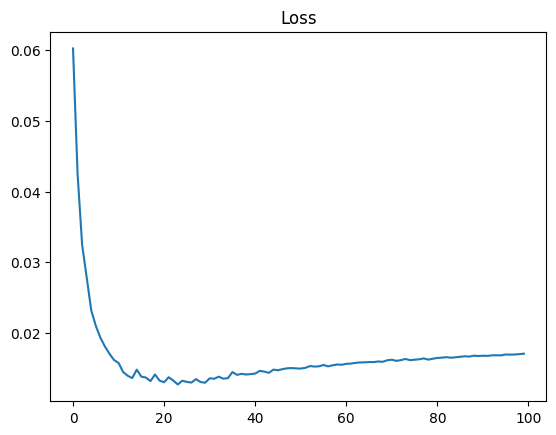

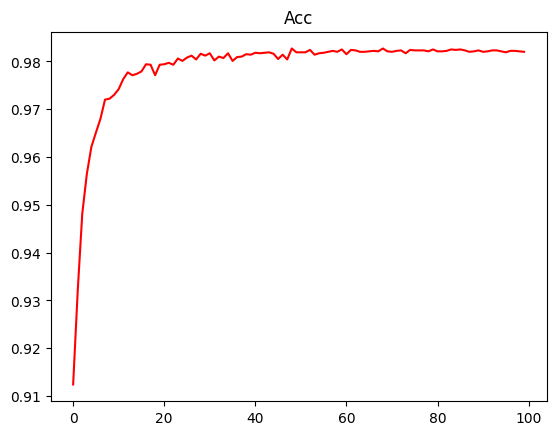

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(history.history['loss'])
plt.title("Loss")
plt.figure(2)
plt.plot(history.history['accuracy'],'r')
plt.title("Acc",)
plt.figure(3)
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.figure(4)
plt.plot(history.history['val_accuracy'],'r')
plt.title("Acc",)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6072 - loss: 0.2184 - val_accuracy: 0.9143 - val_loss: 0.0586
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


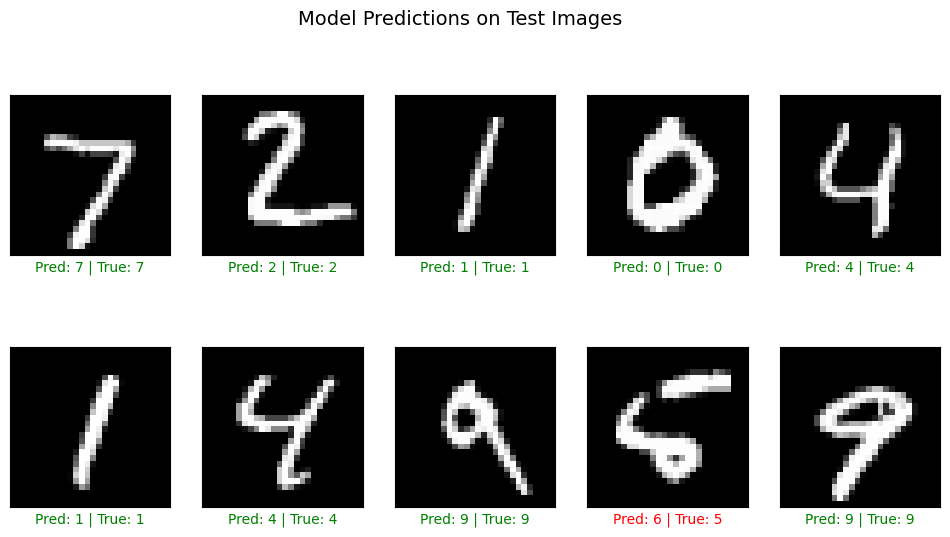

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# --- 1. SETUP & DATA LOADING ---
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# Normalization
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# One-hot encoding (Matching your notebook's style)
y_train_enc = to_categorical(y_train)
y_val_enc = to_categorical(y_val)

# --- 2. MODEL DEFINITION & TRAINING ---
model = tf.keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train_enc, validation_data=(x_val, y_val_enc), epochs=1)

# --- 3. MAKE PREDICTIONS ---
predictions = model.predict(x_val)
pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val_enc, axis=1)

# --- 4. SHOW IMAGES OUTPUT ---
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i], cmap='gray')

    # Green if correct, Red if wrong
    color = 'green' if pred[i] == true_labels[i] else 'red'
    plt.xlabel(f"Pred: {pred[i]} | True: {true_labels[i]}", color=color)

plt.suptitle("Model Predictions on Test Images", fontsize=14)
plt.show()


In [ ]:
#SAVE THE MODEL
# This creates the .h5 file that contains the architecture + trained weights
model.save('mnist_final_model.h5')
print("Success! Model saved as 'mnist_final_model.h5'")

Success! Model saved as 'mnist_final_model.h5'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

# -----------------------------
# LOAD DATA
# -----------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize + Flatten
x_train = x_train.reshape((x_train.shape[0], 28*28)) / 255.0
x_test = x_test.reshape((x_test.shape[0], 28*28)) / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# -----------------------------
# BUILD MODEL (ANN)
# -----------------------------
model = Sequential([
    Dense(512, activation='relu', input_shape=(784,)),
    BatchNormalization(),
    Dropout(0.25),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------------
# TRAIN MODEL
# -----------------------------
history = model.fit(
    x_train, y_train,
    validation_split=0.15,
    epochs=50,              # 50 is enough (not 100)
    batch_size=128,
    verbose=1
)

# -----------------------------
# EVALUATE
# -----------------------------
loss, accuracy = model.evaluate(x_test, y_test)
print(f"\nModel Test Accuracy: {accuracy:.4f}")

model.save("digit_classifier.h5")
print("\nModel saved as digit_classifier.h5 🎉")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8607 - loss: 0.4651 - val_accuracy: 0.9703 - val_loss: 0.1044
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9613 - loss: 0.1228 - val_accuracy: 0.9743 - val_loss: 0.0841
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9711 - loss: 0.0889 - val_accuracy: 0.9764 - val_loss: 0.0793
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9773 - loss: 0.0709 - val_accuracy: 0.9776 - val_loss: 0.0780
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9811 - loss: 0.0627 - val_accuracy: 0.9773 - val_loss: 0.0764
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9827 - loss: 0.0529 - val_accuracy: 0.9788 - val_loss: 0.0767
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9841 - loss: 0.0472 - val_accuracy: 0.9783 - val_loss: 0.0762
Epoch 8/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0442 - val_accuracy: 


Model Test Accuracy: 0.9848

Model saved as digit_classifier.h5 🎉


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist

# -------- Step 1: Load and Normalise Data --------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape to CNN input format
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

# -------- Step 2: Data Augmentation --------
augment = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.25
)

# -------- Step 3: Build CNN Model --------
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -------- Step 4: Train Model --------
history = model.fit(
    augment.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=25
)

# -------- Step 5: Save Model --------
model.save("cnn_handwriting_model.h5")
print("🎉 Model saved as cnn_handwriting_model.h5")

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - accuracy: 0.5431 - loss: 1.3614 - val_accuracy: 0.9211 - val_loss: 0.2537
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8194 - loss: 0.5637 - val_accuracy: 0.9513 - val_loss: 0.1490
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8476 - loss: 0.4716 - val_accuracy: 0.9375 - val_loss: 0.1938
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8660 - loss: 0.4071 - val_accuracy: 0.9615 - val_loss: 0.1254
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8823 - loss: 0.3737 - val_accuracy: 0.9604 - val_loss: 0.1356
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8867 - loss: 0.3539 - val_accuracy: 0.9687 - val_loss: 0.1142
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8920 - loss: 0.3410 - val_accuracy: 0.9597 - val_loss: 0.1375
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8975 - loss: 0.3255 - 

🎉 Model saved as cnn_handwriting_model.h5


In [ ]:
import io
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load trained CNN model
model = tf.keras.models.load_model("cnn_handwriting_model.h5")
print("📌 CNN Model Loaded Successfully!")


upload_btn = widgets.FileUpload(accept="image/*", multiple=False)
output = widgets.Output()

def preprocess(img):
    img = np.array(img)

    # Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold for natural handwriting
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 31, 20
    )

    # Remove small noise
    img = cv2.medianBlur(img, 3)

    # Detect and crop bounding area
    coords = cv2.findNonZero(img)
    x, y, w, h = cv2.boundingRect(coords)
    img = img[y:y+h, x:x+w]

    # Resize maintaining ratio
    h, w = img.shape
    if h > w:
        new_h, new_w = 20, int(w * (20 / h))
    else:
        new_w, new_h = 20, int(h * (20 / w))

    img = cv2.resize(img, (new_w, new_h))

    # Center on 28×28 canvas
    canvas = np.zeros((28,28), dtype=np.uint8)
    xo, yo = (28-new_w)//2, (28-new_h)//2
    canvas[yo:yo+new_h, xo:xo+new_w] = img

    # Normalize
    canvas = canvas.astype("float32") / 255.0
    return canvas.reshape(1,28,28,1)

def on_upload(change):
    if not upload_btn.value: return

    with output:
        clear_output()

        filedata = list(upload_btn.value.values())[0]["content"]
        img = Image.open(io.BytesIO(filedata))

        processed = preprocess(img)

        prediction = model.predict(processed)
        digit = np.argmax(prediction)
        confidence = float(np.max(prediction) * 100)

        plt.imshow(processed.reshape(28,28), cmap="gray")
        plt.title(f"Prediction: {digit}   Confidence: {confidence:.2f}%")
        plt.axis("off")
        plt.show()

upload_btn.observe(on_upload, names="value")
display(upload_btn, output)

📌 CNN Model Loaded Successfully!


FileUpload(value={}, accept='image/*', description='Upload')

Output()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization  # <-- Added BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(4, activation='sigmoid'),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer=SGD(learning_rate=0.05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

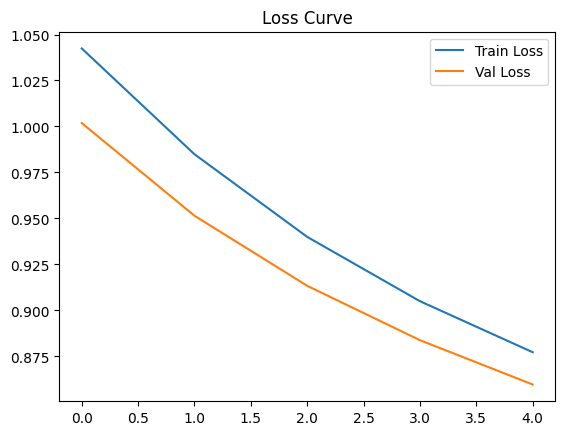

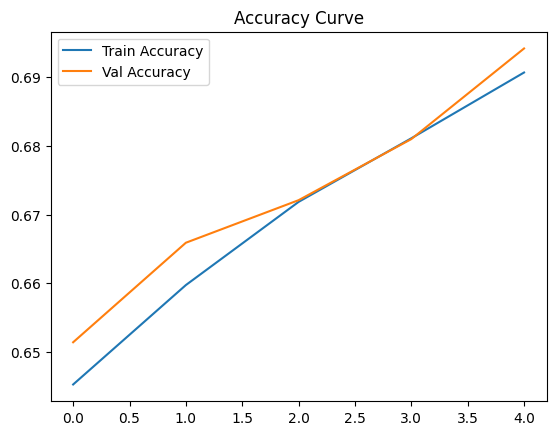

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.figure(2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
model2 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile
model2.compile(
    optimizer=SGD(learning_rate=0.03),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history2 = model2.fit(
    X_train, y_train_cat,
    epochs=6,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    verbose=1
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6575 - loss: 1.2447 - val_accuracy: 0.8895 - val_loss: 0.4189
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8856 - loss: 0.4126 - val_accuracy: 0.9054 - val_loss: 0.3347
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9037 - loss: 0.3403 - val_accuracy: 0.9130 - val_loss: 0.3018
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9140 - loss: 0.3057 - val_accuracy: 0.9198 - val_loss: 0.2811
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9174 - loss: 0.2904 - val_accuracy: 0.9264 - val_loss: 0.2660
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9221 - loss: 0.2743 - val_accuracy: 0.9285 - val_loss: 0.2533


In [ ]:
from tensorflow.keras.optimizers import Adam
model3 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history3 = model3.fit(
    X_train, y_train_cat,
    epochs=8,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    verbose=1
)

Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7669 - loss: 0.7885 - val_accuracy: 0.9374 - val_loss: 0.2107
Epoch 2/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9470 - loss: 0.1850 - val_accuracy: 0.9565 - val_loss: 0.1523
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9606 - loss: 0.1350 - val_accuracy: 0.9628 - val_loss: 0.1270
Epoch 4/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9676 - loss: 0.1083 - val_accuracy: 0.9658 - val_loss: 0.1118
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9743 - loss: 0.0882 - val_accuracy: 0.9689 - val_loss: 0.1054
Epoch 6/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9770 - loss: 0.0770 - val_accuracy: 0.9716 - val_loss: 0.0972
Epoch 7/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9826 - loss: 0.0613 - val_accuracy: 0.9725 - val_loss: 0.0946
Epoch 8/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9839 - loss: 0.0531 - val_accuracy: 0.9709 - v

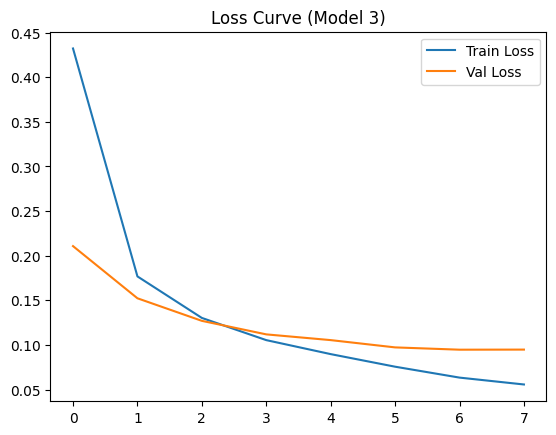

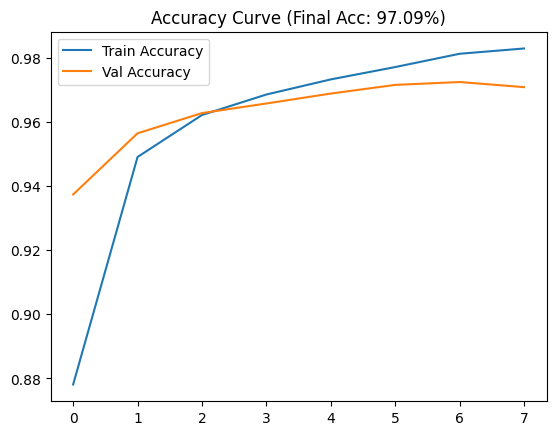

In [ ]:
plt.figure(1)
plt.plot(history3.history['loss'], label="Train Loss")
plt.plot(history3.history['val_loss'], label="Val Loss")
plt.title("Loss Curve (Model 3)")
plt.legend()

plt.figure(2)
plt.plot(history3.history['accuracy'], label="Train Accuracy")
plt.plot(history3.history['val_accuracy'], label="Val Accuracy")
plt.title(f"Accuracy Curve (Final Acc: {history3.history['val_accuracy'][-1]*100:.2f}%)")
plt.legend()

plt.show()

In [ ]:
model4 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(10, activation='softmax')
])

model4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history4 = model4.fit(
    X_train, y_train_cat,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    verbose=1
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8646 - loss: 0.4443 - val_accuracy: 0.9637 - val_loss: 0.1136
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9634 - loss: 0.1204 - val_accuracy: 0.9714 - val_loss: 0.0894
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9722 - loss: 0.0887 - val_accuracy: 0.9734 - val_loss: 0.0815
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9762 - loss: 0.0740 - val_accuracy: 0.9751 - val_loss: 0.0772
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9809 - loss: 0.0605 - val_accuracy: 0.9757 - val_loss: 0.0690
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9826 - loss: 0.0553 - val_accuracy: 0.9799 - val_loss: 0.0615
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9835 - loss: 0.0469 - val_accuracy: 0.9807 - val_loss: 0.0617
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9858 - loss: 0.0419 - val_accuracy: 0

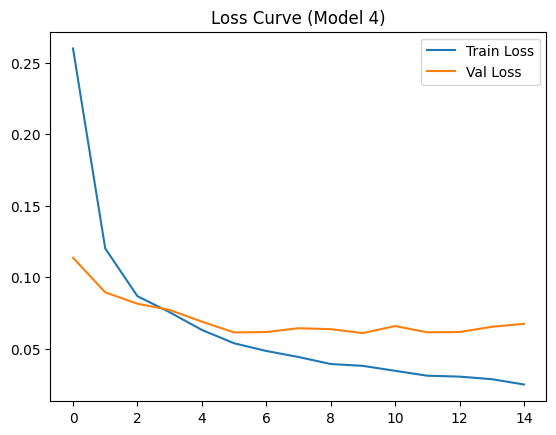

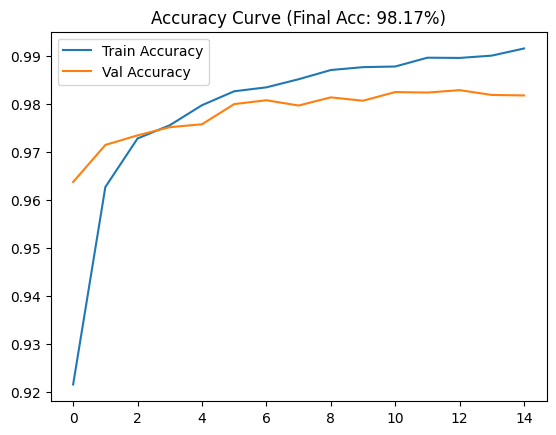

In [ ]:
plt.figure(1)
plt.plot(history4.history['loss'], label="Train Loss")
plt.plot(history4.history['val_loss'], label="Val Loss")
plt.title("Loss Curve (Model 4)")
plt.legend()

plt.figure(2)
plt.plot(history4.history['accuracy'], label="Train Accuracy")
plt.plot(history4.history['val_accuracy'], label="Val Accuracy")
plt.title(f"Accuracy Curve (Final Acc: {history4.history['val_accuracy'][-1]*100:.2f}%)")
plt.legend()

plt.show()

In [ ]:
out = model.predict(X_train.reshape(16,1,4))

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
pred = np.multiply((out > 0.5),1)

NameError: name 'out' is not defined